# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

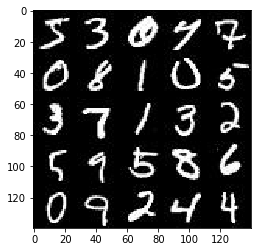

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

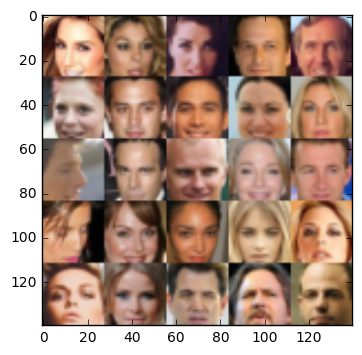

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import helper

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # -0.5 to 0.5 of 28x28
    # For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers.

    alpha = 0.2

    with tf.variable_scope('discriminator', reuse=reuse):

        #in practice disciminator network is deeper with more filters per layer
        #inputs, filter size, kernel
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) #14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2) #7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3) #4x4x256

        #2x2x512
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4) #4x4x256

        #flatten
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
     28 x 28 x out_channel_dim images.
    """
    alpha = 0.2

    with tf.variable_scope('generator', reuse=not is_train):
        #first fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)

        #reshape to start convd stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) #2x2x512


        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2) #4x4x256

        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3) #7x7x128

        #try adding a 4th layer in the generator
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4) #14x14x64

        #output layer 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    #D should already know to label real data as real
    d_model_real, d_logits_real = discriminator(input_real)
    #D needs to learn to tell what is fake
    d_model_fake, d_logits_fake = discriminator(g_model, True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    #Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    total_data_size, image_width, image_height, image_channels = data_shape
    inputs_real, inputs_z, inputs_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)

    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)

    d_opt, g_opt = model_opt(d_loss, g_loss, inputs_learning_rate, beta1)

    print_every = 10
    show_every = 100

    batches = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batches +=1

                #input range is -0.5 , 0.5
                #need to rescale since we're using tanh in final layer of generator
                batch_images = batch_images * 2
                #sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                #run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, inputs_learning_rate: learning_rate})
                #inputs_real needs to be passed in because model_opt needs it to create the optimizer
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_learning_rate: learning_rate, inputs_real: batch_images})

                if batches % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Batch {}/{}...".format(batches, batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))


                if batches % show_every == 0:
                    show_generator_output(sess, 20, inputs_z, image_channels ,data_image_mode)

        print("Training done")
        show_generator_output(sess, 20, inputs_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.7839... Generator Loss: 0.0033
Epoch 1/2... Discriminator Loss: 0.7395... Generator Loss: 5.5903
Epoch 1/2... Discriminator Loss: 2.4948... Generator Loss: 6.2880
Epoch 1/2... Discriminator Loss: 0.6165... Generator Loss: 3.2155
Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 2.6489
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 1.9574
Epoch 1/2... Discriminator Loss: 0.2613... Generator Loss: 1.9061
Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 4.7331
Epoch 1/2... Discriminator Loss: 0.1639... Generator Loss: 2.5011


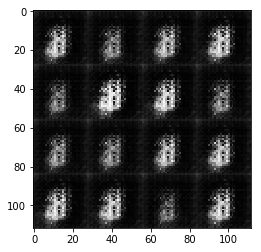

Epoch 1/2... Discriminator Loss: 0.7389... Generator Loss: 4.7702
Epoch 1/2... Discriminator Loss: 0.1986... Generator Loss: 3.7714
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 2.8708
Epoch 1/2... Discriminator Loss: 0.2827... Generator Loss: 2.1141
Epoch 1/2... Discriminator Loss: 0.7314... Generator Loss: 0.8725
Epoch 1/2... Discriminator Loss: 1.2004... Generator Loss: 0.3984
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 1.4781
Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 2.4760... Generator Loss: 0.2140


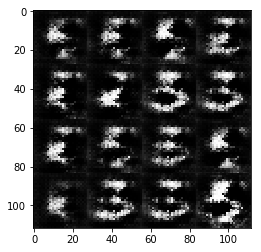

Epoch 1/2... Discriminator Loss: 0.6486... Generator Loss: 1.4877
Epoch 1/2... Discriminator Loss: 0.6783... Generator Loss: 1.0873
Epoch 1/2... Discriminator Loss: 1.3430... Generator Loss: 0.4437
Epoch 1/2... Discriminator Loss: 0.8329... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 0.8727... Generator Loss: 1.1605
Epoch 1/2... Discriminator Loss: 0.8105... Generator Loss: 1.2445
Epoch 1/2... Discriminator Loss: 0.9450... Generator Loss: 0.7938
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 1.6547
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 0.8539
Epoch 1/2... Discriminator Loss: 1.7098... Generator Loss: 5.2611


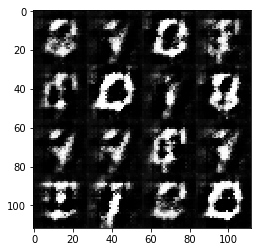

Epoch 1/2... Discriminator Loss: 0.5645... Generator Loss: 2.4741
Epoch 1/2... Discriminator Loss: 0.8290... Generator Loss: 0.9094
Epoch 1/2... Discriminator Loss: 1.0014... Generator Loss: 2.9351
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.3798
Epoch 1/2... Discriminator Loss: 0.4826... Generator Loss: 3.1606
Epoch 1/2... Discriminator Loss: 0.4727... Generator Loss: 1.3947
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 0.3995... Generator Loss: 1.6615
Epoch 1/2... Discriminator Loss: 0.4278... Generator Loss: 1.6360
Epoch 1/2... Discriminator Loss: 0.3258... Generator Loss: 2.0537


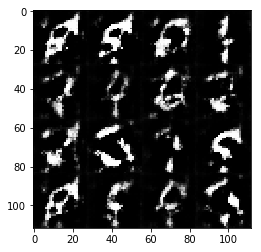

Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 2.1510
Epoch 1/2... Discriminator Loss: 0.7658... Generator Loss: 0.8677
Epoch 1/2... Discriminator Loss: 0.7815... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 0.6417... Generator Loss: 1.1416
Epoch 1/2... Discriminator Loss: 1.0175... Generator Loss: 1.2828
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 0.7713... Generator Loss: 1.1264
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 0.9274... Generator Loss: 1.3276


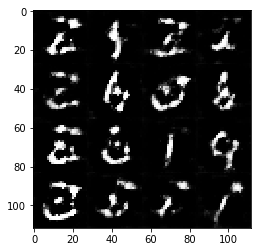

Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 0.3917
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 3.6842
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.1295
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 2.8321
Epoch 1/2... Discriminator Loss: 0.8750... Generator Loss: 1.1017
Epoch 1/2... Discriminator Loss: 0.6601... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 0.6440... Generator Loss: 1.3563
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 0.5676... Generator Loss: 2.0761


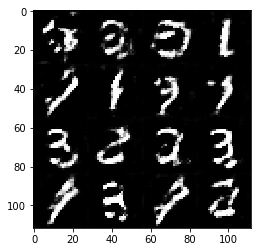

Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.6204
Epoch 1/2... Discriminator Loss: 0.7694... Generator Loss: 1.2897
Epoch 1/2... Discriminator Loss: 0.9356... Generator Loss: 0.9333
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 1.1616
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 1.8861
Epoch 1/2... Discriminator Loss: 0.9520... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 2.9517
Epoch 1/2... Discriminator Loss: 0.7062... Generator Loss: 1.0965
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 2.4527


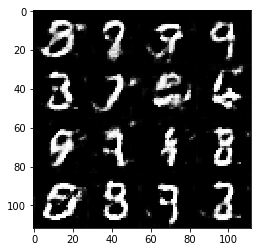

Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 0.4359
Epoch 1/2... Discriminator Loss: 1.0277... Generator Loss: 1.3208
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 0.9219
Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 1.4151
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.3982
Epoch 1/2... Discriminator Loss: 0.7855... Generator Loss: 1.0475
Epoch 1/2... Discriminator Loss: 0.7775... Generator Loss: 0.9477
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 1.2136
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 1.7693


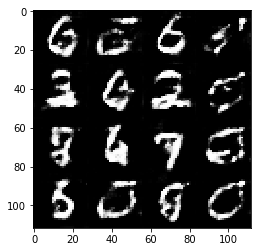

Epoch 1/2... Discriminator Loss: 0.9419... Generator Loss: 1.3355
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 1.0207
Epoch 1/2... Discriminator Loss: 0.7691... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 0.7744... Generator Loss: 3.7475
Epoch 1/2... Discriminator Loss: 0.5861... Generator Loss: 1.2732
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 2.1577
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 2.1232
Epoch 1/2... Discriminator Loss: 0.6672... Generator Loss: 1.4847
Epoch 1/2... Discriminator Loss: 0.7357... Generator Loss: 1.8412
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 0.6020


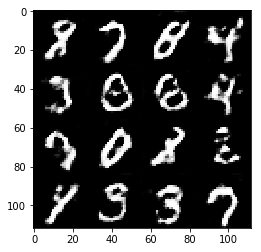

Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 0.7043
Epoch 1/2... Discriminator Loss: 0.6777... Generator Loss: 1.2392
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 2.0328
Epoch 2/2... Discriminator Loss: 1.0265... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.0990
Epoch 2/2... Discriminator Loss: 0.8687... Generator Loss: 1.3072
Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 0.5655
Epoch 2/2... Discriminator Loss: 0.9254... Generator Loss: 0.7213
Epoch 2/2... Discriminator Loss: 1.0213... Generator Loss: 1.0862
Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 2.0575


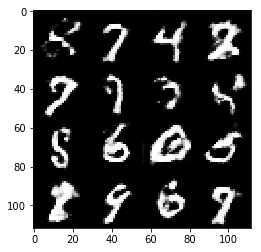

Epoch 2/2... Discriminator Loss: 0.7865... Generator Loss: 0.9590
Epoch 2/2... Discriminator Loss: 0.7524... Generator Loss: 1.1493
Epoch 2/2... Discriminator Loss: 0.6600... Generator Loss: 1.2513
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 2.4724
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 0.7504
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 1.1338... Generator Loss: 0.6447
Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 0.6188
Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 0.9181... Generator Loss: 1.0060


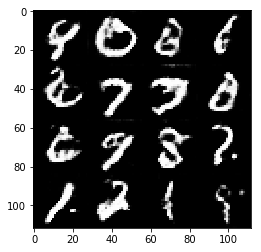

Epoch 2/2... Discriminator Loss: 0.6095... Generator Loss: 1.1717
Epoch 2/2... Discriminator Loss: 0.6300... Generator Loss: 1.5075
Epoch 2/2... Discriminator Loss: 1.5421... Generator Loss: 3.7762
Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 1.9234
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.4232
Epoch 2/2... Discriminator Loss: 1.4769... Generator Loss: 0.3289
Epoch 2/2... Discriminator Loss: 0.6739... Generator Loss: 0.9938


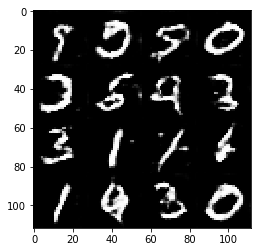

Epoch 2/2... Discriminator Loss: 0.7794... Generator Loss: 2.3546
Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.2007
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 1.1347
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 0.7793... Generator Loss: 1.9977
Epoch 2/2... Discriminator Loss: 1.2281... Generator Loss: 3.6232
Epoch 2/2... Discriminator Loss: 0.8840... Generator Loss: 0.6728
Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 0.6446
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 1.9268
Epoch 2/2... Discriminator Loss: 0.5974... Generator Loss: 2.1327


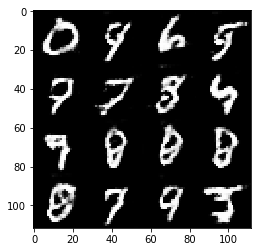

Epoch 2/2... Discriminator Loss: 0.4023... Generator Loss: 1.4437
Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 1.9502
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 2.4713
Epoch 2/2... Discriminator Loss: 0.5880... Generator Loss: 2.0381
Epoch 2/2... Discriminator Loss: 1.5918... Generator Loss: 0.3260
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.4386
Epoch 2/2... Discriminator Loss: 0.6998... Generator Loss: 0.8361
Epoch 2/2... Discriminator Loss: 0.7450... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 0.7828... Generator Loss: 0.7722
Epoch 2/2... Discriminator Loss: 1.0305... Generator Loss: 3.3155


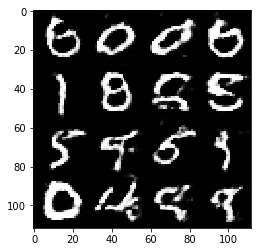

Epoch 2/2... Discriminator Loss: 1.4871... Generator Loss: 0.3289
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 0.6392
Epoch 2/2... Discriminator Loss: 1.1686... Generator Loss: 0.4514
Epoch 2/2... Discriminator Loss: 0.7947... Generator Loss: 2.6490
Epoch 2/2... Discriminator Loss: 0.7743... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 0.8876... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 0.6717... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 0.5217... Generator Loss: 1.3012
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 2.4374
Epoch 2/2... Discriminator Loss: 0.5756... Generator Loss: 1.0242


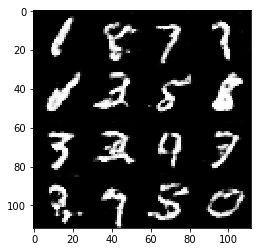

Epoch 2/2... Discriminator Loss: 0.8111... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.6476
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 1.0570
Epoch 2/2... Discriminator Loss: 0.5514... Generator Loss: 1.1509
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 0.9731
Epoch 2/2... Discriminator Loss: 1.5775... Generator Loss: 4.6498
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.4548
Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 0.9350
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 2.3718
Epoch 2/2... Discriminator Loss: 0.6755... Generator Loss: 1.1490


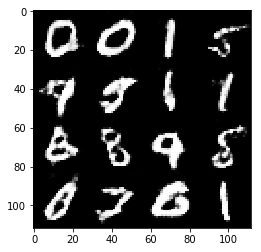

Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.0412
Epoch 2/2... Discriminator Loss: 1.9129... Generator Loss: 0.2854
Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 0.6261... Generator Loss: 2.0038
Epoch 2/2... Discriminator Loss: 0.4350... Generator Loss: 1.3719
Epoch 2/2... Discriminator Loss: 0.5996... Generator Loss: 1.2375
Epoch 2/2... Discriminator Loss: 0.7705... Generator Loss: 0.9531
Epoch 2/2... Discriminator Loss: 0.7869... Generator Loss: 1.0904
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 0.9765


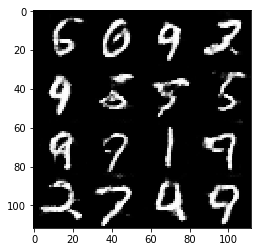

Epoch 2/2... Discriminator Loss: 0.6827... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 0.6544... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 0.8772... Generator Loss: 1.4491
Epoch 2/2... Discriminator Loss: 0.6006... Generator Loss: 1.2251
Epoch 2/2... Discriminator Loss: 1.1802... Generator Loss: 3.2706
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 1.7642... Generator Loss: 0.2763
Epoch 2/2... Discriminator Loss: 1.4279... Generator Loss: 0.4165
Epoch 2/2... Discriminator Loss: 0.5335... Generator Loss: 1.1834
Epoch 2/2... Discriminator Loss: 1.2913... Generator Loss: 0.4136


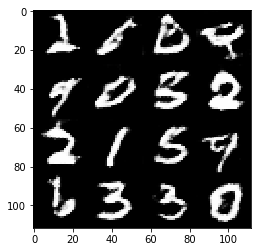

Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 0.7212
Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 0.8234
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 0.4885
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 0.9679
Epoch 2/2... Discriminator Loss: 1.6730... Generator Loss: 3.4373
Epoch 2/2... Discriminator Loss: 1.6245... Generator Loss: 0.2724
Epoch 2/2... Discriminator Loss: 1.6738... Generator Loss: 0.2775
Training done


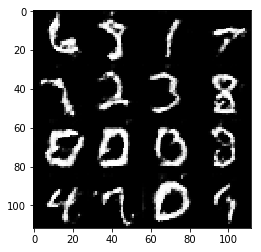

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.3675
Epoch 1/1... Discriminator Loss: 4.6321... Generator Loss: 0.1039
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 2.5654
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 2.1585
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 2.4540
Epoch 1/1... Discriminator Loss: 2.4735... Generator Loss: 0.1706
Epoch 1/1... Discriminator Loss: 2.5541... Generator Loss: 0.1139
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.7310


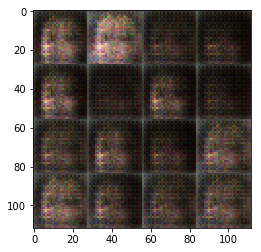

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.8810
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.6180


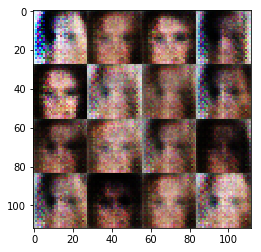

Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.2131


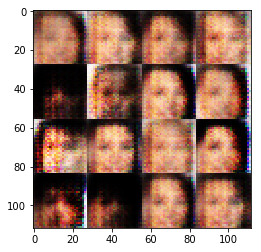

Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.4018
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 2.0956
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.7924
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 1.5224
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 1.8061
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.8268


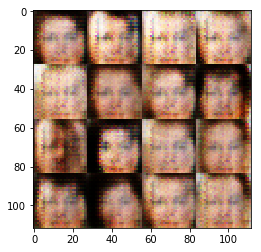

Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 1.8456
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.3788
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 2.0585
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.8548... Generator Loss: 0.2183
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 0.8902


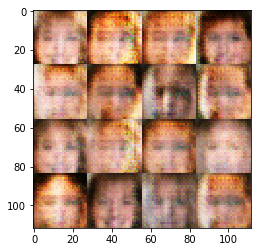

Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.3375
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 2.1145... Generator Loss: 2.9036
Epoch 1/1... Discriminator Loss: 2.0353... Generator Loss: 0.2029
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 0.6819


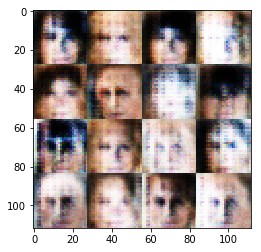

Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 1.9638
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.6813
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.7178
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 1.6444... Generator Loss: 2.7322
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.5807
Epoch 1/1... Discriminator Loss: 1.6901... Generator Loss: 2.8242


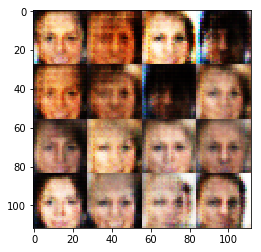

Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 3.1387... Generator Loss: 0.0618
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.3514
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.6593


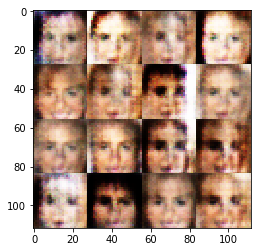

Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.2343
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.3355
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.3276
Epoch 1/1... Discriminator Loss: 1.6661... Generator Loss: 0.2690
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 2.0605
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 2.3716... Generator Loss: 0.1184
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.3777
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.5283


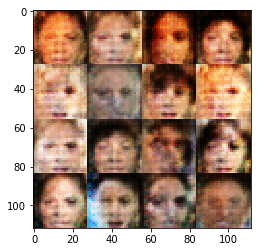

Epoch 1/1... Discriminator Loss: 1.6950... Generator Loss: 3.0388
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.4734
Epoch 1/1... Discriminator Loss: 0.7236... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.3011
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 2.2573... Generator Loss: 0.1369
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.5316


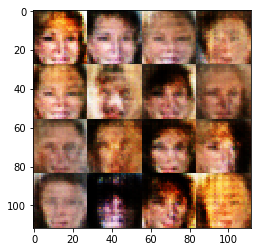

Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 3.1117
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.6502


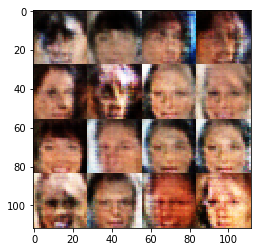

Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 2.3920... Generator Loss: 3.7747
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 1.1207
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 2.6669
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 0.9170


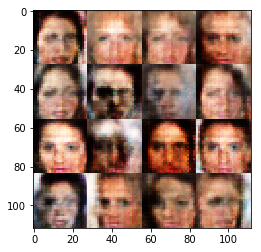

Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.9297
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.9191
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.7404... Generator Loss: 0.2225
Epoch 1/1... Discriminator Loss: 1.7181... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.9339
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.2910


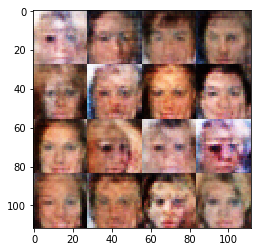

Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 2.1559
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 2.1076
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 1.8595... Generator Loss: 3.4742
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 2.4127
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.3877
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 2.1956
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.8358


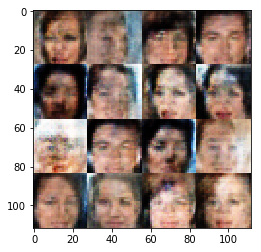

Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.3877
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 2.2163
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.3500
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 1.3560
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 0.6459


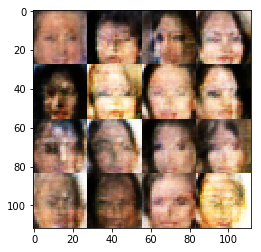

Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.5224
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 2.3500
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 1.5790
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 2.8166... Generator Loss: 3.0995
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 1.2123


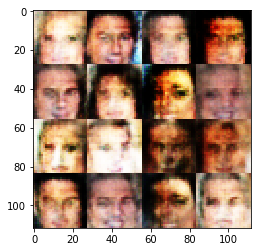

Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 1.5559
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 1.8407
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.3705
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 3.1234


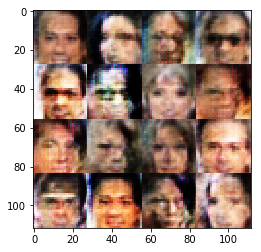

Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.3422
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.4769
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.9961
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 2.9781
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.9753
Epoch 1/1... Discriminator Loss: 1.7922... Generator Loss: 0.2720
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 1.8308


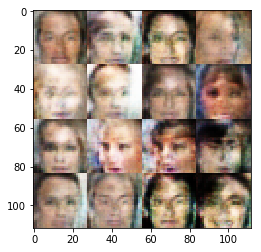

Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 3.0310
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 2.6743


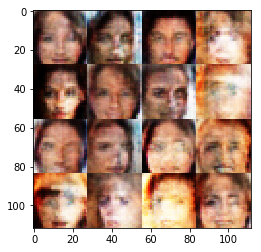

Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 1.4887
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.5559
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.3352
Epoch 1/1... Discriminator Loss: 4.4462... Generator Loss: 5.1426
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 0.7007


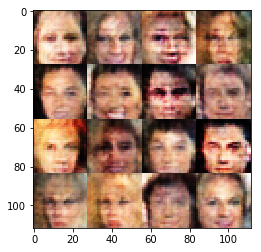

Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 2.5251
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 1.3139
Epoch 1/1... Discriminator Loss: 1.5873... Generator Loss: 0.3239
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 1.6973
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.7643
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.0466


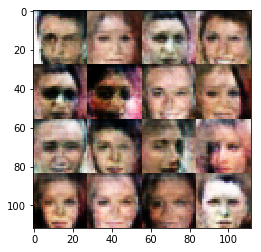

Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 1.5197
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.8334... Generator Loss: 3.1281
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 2.7685
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.4088
Epoch 1/1... Discriminator Loss: 3.2645... Generator Loss: 4.9551


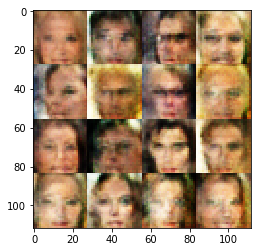

Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.3659
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 1.9797... Generator Loss: 4.4709
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 2.0440
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.1002
Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 1.3536


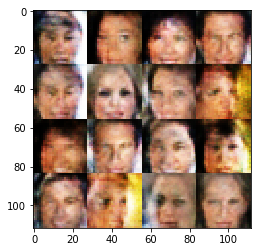

Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.7790
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.5088
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 0.7144... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 1.7743... Generator Loss: 0.2329
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.4341


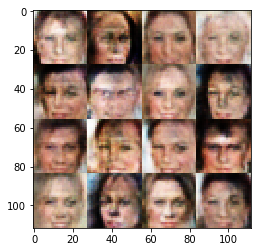

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.